In [2]:
import matplotlib.pyplot as plt
import supervision as sv
import numpy as np
import os
import random
import cv2

In [57]:

base_path = "./datasets/parking_spot/bbox/test/images/"
label_base_path = "./datasets/parking_spot/bbox/test/labels/"
count = 6
files = []
labels = dict()

all_files = [f for f in os.listdir(base_path) if os.path.isfile(os.path.join(base_path, f))]
# Randomly pick the specified number of files
random.seed(0)
random_files = random.sample(all_files, count)

for filename in random_files:

    file_path = base_path+filename
    files.append(file_path)
    img = cv2.imread(file_path)
    h, w, channels = img.shape
    
    labels[file_path] = {
        "bbox": [],
        "class": []  # 0 is occupied 1 is not
    }
    
    with open(label_base_path+filename.replace(".jpg", ".txt"), "r") as f:
        for line in f:
            vals = line.strip().split(" ")
            vals = list(map(lambda x:float(x), vals))
            x1 = vals[1] - vals[3]/2
            y1 = vals[2] - vals[4]/2
            x2 = vals[1] + vals[3]/2
            y2 = vals[2] + vals[4]/2
            labels[file_path]["class"].append(vals[0])
            labels[file_path]["bbox"].append( [x1 * w, y1 * h, x2 * w, y2 * h] )     

    count -= 1

In [46]:
from ultralytics import YOLO,RTDETR

model = YOLO("runs/detect/exp_traditional/weights/best.pt")


image 1/1 /media/nabil/Games/ml_project/yolo/datasets/parking_spot/bbox/test/images/frame_18_71_jpg.rf.ba65e30303a256f6f7594c1efb5a7225.jpg: 288x640 2 cars, 18.1ms
Speed: 2.0ms preprocess, 18.1ms inference, 2.2ms postprocess per image at shape (1, 3, 288, 640)



image 1/1 /media/nabil/Games/ml_project/yolo/datasets/parking_spot/bbox/test/images/frame_14_59_jpg.rf.76c1981476bacd5d73a2440e5c0393c7.jpg: 288x640 12 cars, 15.2ms
Speed: 1.4ms preprocess, 15.2ms inference, 1.8ms postprocess per image at shape (1, 3, 288, 640)


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


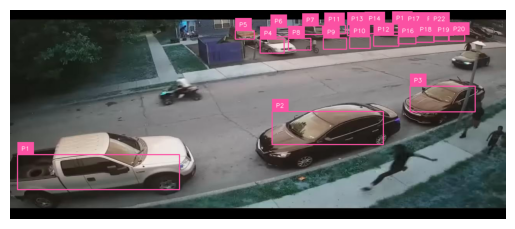

In [76]:
detection_data = {
    "xyxy": [],
    "class_id": [],
    "confidence": []
}

file_path = files[4]
results = model.predict(file_path, conf=0.6)

img = cv2.imread(file_path)
height, width, channels = img.shape
car_boxes = [ box.xyxy.tolist()[0] for box in results[0].boxes ]

for label_box_i, _ in enumerate(labels[file_path]["bbox"]):
    label_class = labels[file_path]["class"][label_box_i]
    detection_data["xyxy"].append(np.array(labels[file_path]["bbox"][label_box_i]))
    detection_data["class_id"].append( 0 )
    detection_data["confidence"].append( "P"+str(label_box_i+1) )

# for car_box_i, _ in enumerate(car_boxes):
#     detection_data["xyxy"].append(np.array(car_boxes[car_box_i]))
#     detection_data["class_id"].append( 1 )
#     detection_data["confidence"].append( "C"+str(car_box_i+1) )

detections = sv.Detections(
    xyxy= np.array(detection_data["xyxy"]),
    class_id= np.array(detection_data["class_id"]),
    confidence= np.array(detection_data["confidence"])
)

bounding_box_annotator = sv.BoundingBoxAnnotator()
annotated_frame = bounding_box_annotator.annotate(
    scene=img.copy(),
    detections=detections,
)


label_annotator = sv.LabelAnnotator()
annotated_image = label_annotator.annotate(
    scene=annotated_frame, 
    detections=detections, 
    labels=list(map( lambda x:str(x), detection_data["confidence"]))
)

plt.axis('off')
plt.imshow(annotated_frame)